In [1]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import tqdm
import sys
import torch
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"
print("device =", device)

device = cpu


In [16]:
def load_data(in_path):
    pball = {"m": [], "d": [], "y": [], "num": [], "pball": [], "pplay": []}
    with open(in_path, "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        # headers = ["type", "month", "day", "year", "1", "2", "3", "4", "5", "powerball", "powerplay"]
        for row_idx, row_str in enumerate(csv_reader):
            row = [int(row_str[i]) for i in range(1, len(row_str))]
            row.insert(0, None)

            month = row[1]
            day = row[2]
            year = row[3]
    
    
            """
            Beginning with the October 31, 2017 drawing, 
            the game matrix changed from "1 to 75" white balls to "1 to 70" white balls, 
            and from "1 to 15" Mega Balls to "1 to 25" Mega Balls.
            """
            if year < 2017:
                continue
            elif year == 2017 and month < 10:
                continue
            elif year == 2017 and month == 10 and day < 31:
                continue
                
            numbers = [row[4], row[5], row[6], row[7], row[8]]
            powerball = row[9]
            if len(row) == 11:
                powerplay = row[10]
            else:
                assert False
                powerplay = 1

            pball["y"].append(year)
            pball["m"].append(month)
            pball["d"].append(day)
            pball["num"].append(numbers)
            pball["pball"].append(powerball)
            pball["pplay"].append(powerplay)

        for k, v in pball.items():
            pball[k] = np.array(v).astype(int)
            print(k, ":", pball[k].shape)
        print()
    return pball

# in_dir = "/content/drive/MyDrive/Colab Notebooks/220110_Lottery/inputs"
in_dir = "inputs"
in_path = os.path.join(in_dir, "megamillions_2003_2022.csv")
pball = load_data(in_path)

def parse_data(pball):
    outputs = []
    inputs = []
    seq_length = len(pball["y"])
    for i in range(seq_length):
        num = pball["num"][i]
        num_pball = pball["pball"][i]
        output = list(num)
        output.append(num_pball)
        outputs.append(output)

        year = pball["y"][i]
        month = pball["m"][i]
        day = pball["d"][i]

        # min-max normalize [0, 1]
        y = (year-2017) / (2022-2017)
        m = (month) / 12
        d = (day) / 31

        flag_y = float((year % 2) == 0)
        flag_m = float((month & 2) == 0)
        flag_d = float((day & 2) == 0)

        inputs.append([y, m, d, flag_y, flag_m, flag_d])
    outputs = np.float32(outputs)
    inputs = np.float32(inputs)
    return inputs, outputs

inputs, outputs = parse_data(pball)
print("input:", inputs.shape, ", outputs:", outputs.shape)

def one_hot_encode(y, num_classes):
    # y: (seq_length, num_classes)
    seq_length = y.shape[0]
    ys = np.zeros((seq_length, num_classes)).astype(np.float32)
    for s in range(seq_length):
        for c in range(len(y[s])):
            ys[s, int(y[s, c])-1] = 1.0
    return ys

outputs_num = one_hot_encode(outputs[:, 0:5], 70)
outputs_pball = one_hot_encode(outputs[:, 5][:, None], 25)

inputs = torch.Tensor(inputs).to(device)
outputs_num = torch.Tensor(outputs_num).to(device)
outputs_pball = torch.Tensor(outputs_pball).to(device)
print("\none hot encoded")
print("  - num  :", outputs_num.shape)
print("  - pball:", outputs_pball.shape)

m : (439,)
d : (439,)
y : (439,)
num : (439, 5)
pball : (439,)
pplay : (439,)

input: (439, 6) , outputs: (439, 6)

one hot encoded
  - num  : torch.Size([439, 70])
  - pball: torch.Size([439, 25])


In [17]:
class PowerballDataset(torch.utils.data.Dataset):
    def __init__(self, x, y_num, y_pball):
        self.x = x
        self.y_num = y_num
        self.y_pball = y_pball

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y_num[i], self.y_pball[i]

# make batches
L_per_batch = 400

inputs_batch = []
outputs_batch = {"num": [], "pball": []}

# inputs
L = len(inputs) # seq length
n_test = 39
# inputs_batch.append(inputs[0:L_per_batch, :])
# inputs_batch.append(inputs[L-n_test-L_per_batch:L-n_test, :])
inputs_batch.append(inputs[0:-n_test, :])

# outputs
# outputs_batch["num"].append(outputs_num[0:L_per_batch, :])
# outputs_batch["num"].append(outputs_num[L-n_test-L_per_batch:L-n_test, :])
# outputs_batch["pball"].append(outputs_pball[0:L_per_batch, :])
# outputs_batch["pball"].append(outputs_pball[L-n_test-L_per_batch:L-n_test, :])
outputs_batch["num"].append(outputs_num[0:-n_test, :])
outputs_batch["pball"].append(outputs_pball[0:-n_test, :])

for i in range(len(inputs_batch)):
    print("batch {}: input={}, outputs={} and {}".format(i, inputs_batch[i].shape, outputs_batch["num"][i].shape, outputs_batch["pball"][i].shape))

powerball_dataset = PowerballDataset(x=inputs_batch, y_num=outputs_batch["num"], y_pball=outputs_batch["pball"])

batch_size = 1
data_generator = torch.utils.data.DataLoader(powerball_dataset, batch_size=batch_size, shuffle=False)

x, y_num, y_pball = powerball_dataset[0]
print(x.shape, y_num.shape, y_pball.shape)
n_batch = len(data_generator)
print("  - batch_size =", batch_size)
print("  - n_batch    =", n_batch)
for x_batch, y_num_batch, y_pball_batch in data_generator:
    print(x_batch.shape, y_num_batch.shape, y_pball_batch.shape)
    

batch 0: input=torch.Size([400, 6]), outputs=torch.Size([400, 70]) and torch.Size([400, 25])
torch.Size([400, 6]) torch.Size([400, 70]) torch.Size([400, 25])
  - batch_size = 1
  - n_batch    = 1
torch.Size([1, 400, 6]) torch.Size([1, 400, 70]) torch.Size([1, 400, 25])


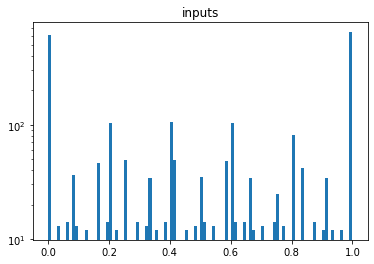

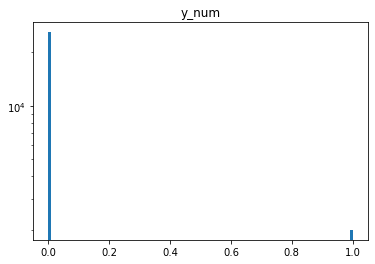

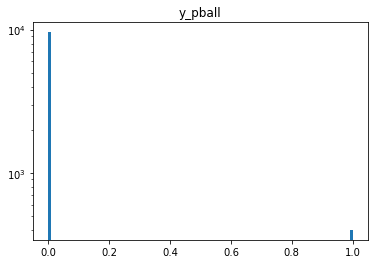

Loss: 0.31579:  23%|█████▊                   | 690/3000 [00:50<01:44, 22.20it/s]

In [18]:
plt.figure()
plt.hist(x.flatten().numpy(), bins=100)
plt.title("inputs")
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(y_num.flatten().numpy(), bins=100)
plt.title("y_num")
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(y_pball.flatten().numpy(), bins=100)
plt.title("y_pball")
plt.yscale("log")
plt.show()

# Model

In [23]:
import torch
from torch.autograd import Variable

class PowerballLSTM(torch.nn.Module):
    def __init__(self, number_dim, powerball_dim, input_size, hidden_size, num_layers, seq_length, device):
        super(PowerballLSTM, self).__init__()
        self.device = device
        self.number_dim = number_dim
        self.powerball_dim = powerball_dim
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        print("input_size:", input_size, ", hidden_size:", hidden_size)
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        print(self.lstm)
        self.fc1 = torch.nn.Linear(hidden_size, hidden_size*2)
        self.fc_num = torch.nn.Linear(hidden_size*2, number_dim)
        self.fc_pball = torch.nn.Linear(hidden_size*2, powerball_dim)
        self.relu = torch.nn.LeakyReLU()
        self.softmax = torch.nn.Softmax(dim=2)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        """
        x: (B, N, D) = (batch, seq length, feature dim)
        h_0, c_0: (num_layers, batch, hidden size)
        output: (B, N, D2)
        """
        batch_size = x.shape[0]
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) # hidden state
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) # internal state
        
        # propagate through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output)
        out = self.fc1(out)
        out = self.relu(out)
        
        out_num = self.fc_num(out)
#         out_num = self.relu(out_num)
        out_num = self.sigmoid(out_num)
        
        out_pball = self.fc_pball(out)
#         out_pball = self.relu(out_pball)
        out_pball = self.softmax(out_pball)
        return out_num, out_pball
    
num_epochs = 3000 # epochs
learning_rate = 0.01 #0.001 lr
input_size = x.shape[-1] # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

# number of output classes 
num_dim = 70
powerball_dim = 25
seq_length = x.shape[0]

model = PowerballLSTM(num_dim, powerball_dim, input_size, hidden_size, num_layers, seq_length, device).to(device) # our lstm class 
print(next(model.parameters()).is_cuda)
BCELoss = torch.nn.BCELoss()
BCELossMultiLabel = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2000, 3000], gamma=0.1)
for name in model.named_parameters():
    print(name[0], " -> ", name[1].shape)


input_size: 6 , hidden_size: 32
LSTM(6, 32, batch_first=True)
False
lstm.weight_ih_l0  ->  torch.Size([128, 6])
lstm.weight_hh_l0  ->  torch.Size([128, 32])
lstm.bias_ih_l0  ->  torch.Size([128])
lstm.bias_hh_l0  ->  torch.Size([128])
fc1.weight  ->  torch.Size([64, 32])
fc1.bias  ->  torch.Size([64])
fc_num.weight  ->  torch.Size([70, 64])
fc_num.bias  ->  torch.Size([70])
fc_pball.weight  ->  torch.Size([25, 64])
fc_pball.bias  ->  torch.Size([25])


In [24]:
losses = {"total": [], "num": [], "pball": []}
save_dir = os.path.join("outputs/models/")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "model_megamillions.pt")
pbar = tqdm.tqdm(total=num_epochs, file=sys.stdout)
model.train()
print("batch_size:", batch_size)
for epoch in range(num_epochs):
    loss_batch = 0.0
    loss_num = 0.0
    loss_pball = 0.0
    for x_batch, y_num_batch, y_pball_batch in data_generator:
        # forward pass: (B, SeqLength, N)
        pred_num, pred_pball = model(x_batch)
        if epoch == 0:
            print("input:", x_batch.shape)
            print("output:", pred_num.shape, pred_pball.shape)
            print("gt    :", y_num_batch.shape, y_pball_batch.shape)
            print("pball range: pred=", pred_pball.min().item(), ", ", pred_pball.max().item(), "\tgt=", y_pball_batch.min(), ", ", y_pball_batch.max())
        optimizer.zero_grad()
        
#         if epoch % 200 == 0:
#             p1 = pred_num[0, :, :].flatten()
#             p2 = y_num_batch[0, :, :].flatten()
# #             p1 = pred_pball.flatten()
# #             p2 = y_pball_batch.flatten()
#             plt.figure(figsize=(20, 1))
#             plt.plot(p1.detach().cpu().numpy(), "o", c='b')
#             plt.plot(p2.detach().cpu().numpy(), "x", c='r')
#             plt.title("Epoch: {} | loss: {:.4f}".format(epoch, l_num))
#             print("\n>> num range: pred=", pred_num.min().item(), ", ", pred_num.max().item(), "\tgt=", y_num_batch.min(), ", ", y_num_batch.max())
#             plt.ylim([0, 1])
#             plt.show()
        l_num = BCELossMultiLabel(pred_num, y_num_batch)
        l_pball = BCELoss(pred_pball, y_pball_batch)
        loss = l_num + l_pball
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_batch += loss.item()
        loss_num += l_num.item()
        loss_pball += l_pball.item()
        
    losses["total"].append(loss_batch / batch_size)
    losses["num"].append(loss_num / batch_size)
    losses["pball"].append(loss_pball / batch_size)
    if epoch % 10 == 0:
        pbar.set_description('Loss: {:.5f}'.format(losses["total"][-1]))
        pbar.update(10)
    
    # save model
    if epoch > 0 and epoch % 1000 == 0:
        torch.save(model.state_dict(), save_path)
        print("\nmodel saved:", save_path)
#     break
pbar.close()



Loss: 14.59284:  95%|█████████████████████▉ | 2860/3000 [02:10<00:06, 21.87it/s]
batch_size: 1
input: torch.Size([1, 400, 6])
output: torch.Size([1, 400, 70]) torch.Size([1, 400, 25])
gt    : torch.Size([1, 400, 70]) torch.Size([1, 400, 25])
pball range: pred= 0.03316863626241684 ,  0.048776403069496155 	gt= tensor(0.) ,  tensor(1.)

Loss: 0.31862:  16%|███▉                     | 470/3000 [00:21<01:56, 21.77it/s]


Loss: 0.12293:  32%|███████▉                 | 950/3000 [00:43<01:34, 21.73it/s]


Loss: 0.11493:  34%|████████                | 1010/3000 [00:45<01:31, 21.74it/s]
model saved: outputs/models/model.pt

Loss: 0.05719:  48%|███████████▌            | 1440/3000 [01:05<01:12, 21.56it/s]


Loss: 0.02716:  64%|███████████████▎        | 1920/3000 [01:28<00:49, 22.03it/s]


Loss: 0.02283:  67%|████████████████        | 2010/3000 [01:32<00:45, 21.69it/s]
model saved: outputs/models/model.pt

Loss: 0.02091:  80%|███████████████████▎    | 2410/3000 [01:50<00:27, 21.82it/s]


Loss: 0.01851:  96%|███████████████████████ | 2890/3000 [02:12<00:05, 21.67it/s]


Loss: 0.01800: 100%|████████████████████████| 3000/3000 [02:17<00:00, 21.74it/s]


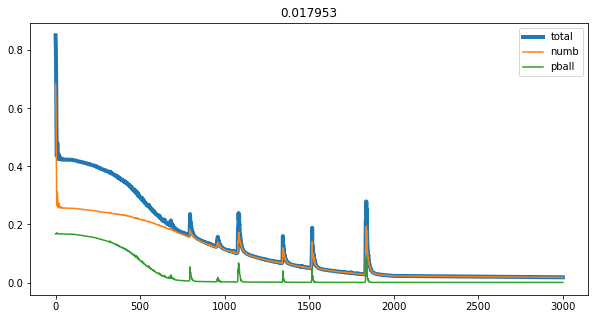

In [25]:
plt.figure(figsize=(10, 5))
legends = []
plt.plot(losses["total"], linewidth=4)
legends.append("total")
plt.plot(losses["num"])
legends.append("numb")
plt.plot(losses["pball"])
legends.append("pball")
plt.title("{:.6f}".format(losses["total"][-1]))
plt.legend(legends)
plt.show()

In [26]:
def probs2integers(prob, is_pred=True):
    """
    prob: [B, SeqLength, N]
    """
    n_batch = prob.shape[0]
    assert n_batch == 1

    top_fives = []
    seq_length = prob.shape[1]
    print("prob:", prob.shape)
    if is_pred:
        indices = np.argsort(prob, axis=2)
        for i in range(seq_length):
            v = []
            idx = indices[0, i, :]
            for j in range(70-5, 70):
                v.append(idx[j]+1)
            top_fives.append(v)
    else:
        for i in range(seq_length):
            v = []
            for j in range(prob.shape[2]):
                if int(prob[0, i, j]) == 1:
                    v.append(j+1)
            top_fives.append(v)
    top_fives = np.array(top_fives).astype(int)
    return top_fives

def predict(model, x_in):
    model.eval()
    print("x_in:", x_in.shape)
    pred_num, pred_pball = model(x_in)
    pred_num = pred_num.detach().cpu().numpy()
    pball_pred = np.argmax(pred_pball.detach().cpu().numpy(), axis=2).squeeze() + 1
    
    indices = np.argsort(pred_num, axis=1)
    top_fives = probs2integers(pred_num, is_pred=True)
    return top_fives, pball_pred

i1 = 0
i2 = 675
x = inputs[None, i1:i2, :]
pball_gt = np.argmax(y_pball.numpy().astype(int), axis=1) + 1
num_pred, pball_pred = predict(model, x)

print("predicted:", num_pred.shape, pball_pred.shape)


x_in: torch.Size([1, 439, 6])
prob: (1, 439, 70)
predicted: (439, 5) (439,)


outputs_pball: torch.Size([439, 25]) (439,) (439,)
prob: (1, 439, 70)
seq_length: 439


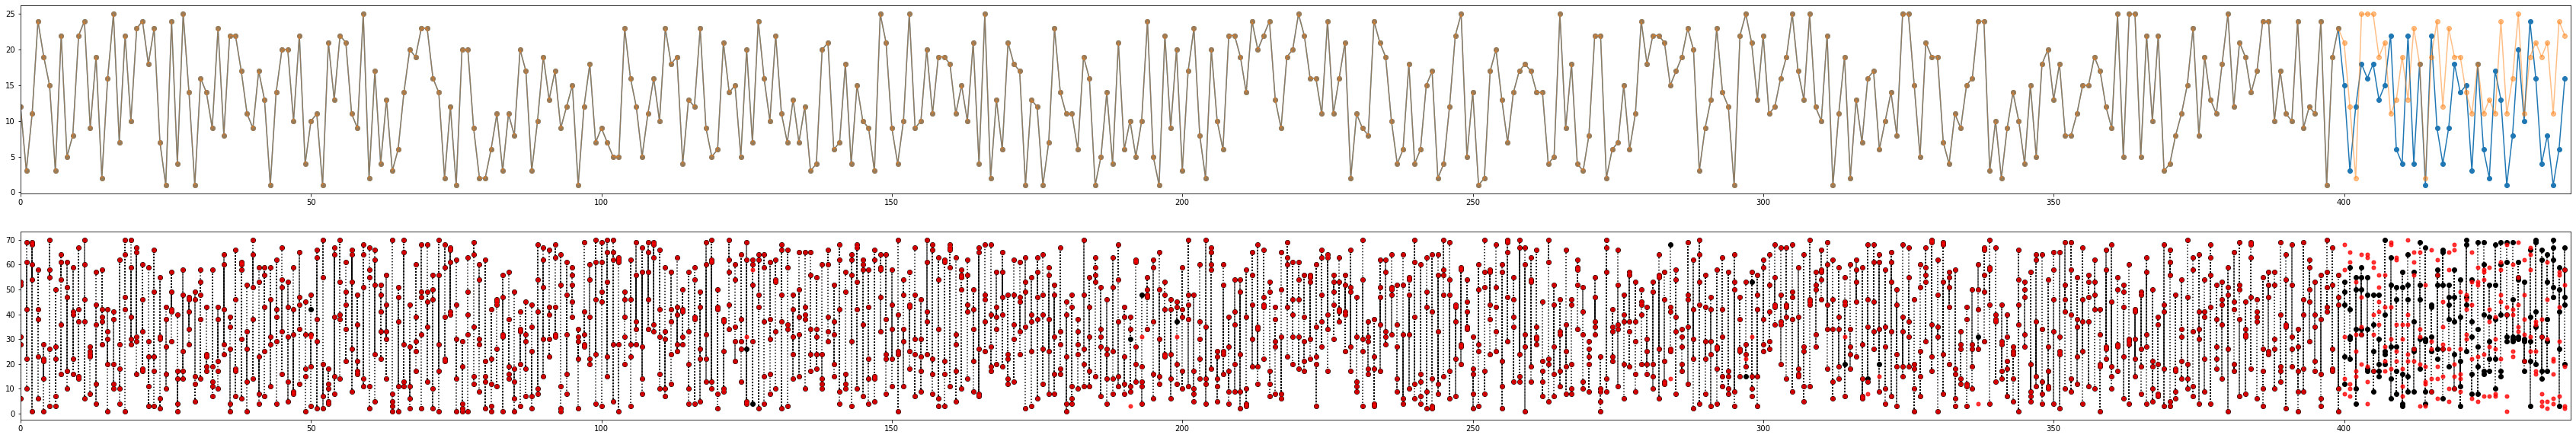

In [28]:
fig = plt.figure(figsize=(60, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

pball_gts = np.argmax(outputs_pball.numpy(), axis=1) + 1
print("outputs_pball:", outputs_pball.shape, pball_gts.shape, pball_pred.shape)
ax1.plot(pball_gts[i1:i2], "-o")
ax1.plot(pball_pred, "-o", alpha=0.5)

colors = ['k']
out_num_ints = probs2integers(outputs_num[None, i1:i2, :].numpy(), is_pred=False)
seq_length = x.shape[1]
for s in range(seq_length):
    nums = num_pred[s, :]
    nums_gt = out_num_ints[s, :]
    ax2.plot(np.ones((5,))*s, nums, ':o', c=colors[s%len(colors)])
    ax2.plot(np.ones((5,))*s, nums_gt, 'o', c='r', markersize=5, alpha=0.8)
print("seq_length:", seq_length)
ax1.set_xlim([0, seq_length])
ax2.set_xlim([0, seq_length])
plt.show()

# Predict using a new date

In [32]:
def convert_input(x):
    year = x["year"]
    month = x["month"]
    day = x["day"]
    
    # min-max normalize [0, 1]
    y = (year-2017) / (2022-2017)
    m = (month) / 12
    d = (day) / 31

    flag_y = float((year % 2) == 0)
    flag_m = float((month & 2) == 0)
    flag_d = float((day & 2) == 0)
    
    return torch.Tensor([y, m, d, flag_y, flag_m, flag_d])
new_x = {"year": 2022, "month": 1, "day": 15}
new_x = convert_input(new_x)[None, None, :]
print(new_x.shape)

# forward

i1 = 0
i2 = 439
x = inputs[None, i1:i2, :]
print(x.shape)
x = torch.cat([x, new_x], dim=1)
print(x.shape)
num_pred, pball_pred = predict(model, x)
print("predicted:", num_pred.shape, pball_pred.shape)

print("============================")
print("prediction")
print("  - numbers  : {}".format(sorted(num_pred[-1, :])))
print("  - powerball: {}".format(pball_pred[-1]))

torch.Size([1, 1, 6])
torch.Size([1, 439, 6])
torch.Size([1, 440, 6])
x_in: torch.Size([1, 440, 6])
prob: (1, 440, 70)
predicted: (440, 5) (440,)
prediction
  - numbers  : [13, 14, 26, 44, 47]
  - powerball: 21


outputs_pball: torch.Size([439, 25]) (439,) (440,)
prob: (1, 439, 70)
seq_length: 440


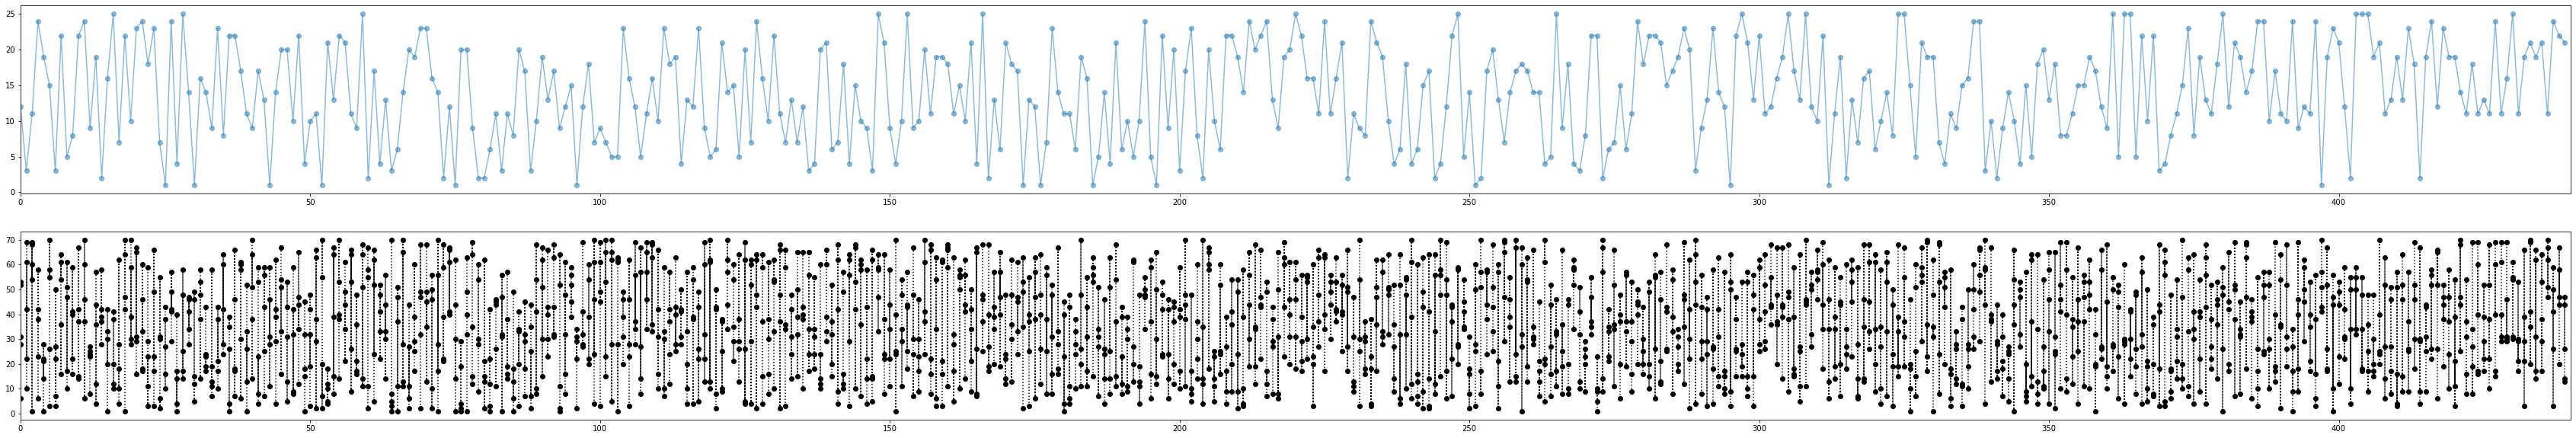

In [31]:
fig = plt.figure(figsize=(60, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

pball_gts = np.argmax(outputs_pball.numpy(), axis=1) + 1
print("outputs_pball:", outputs_pball.shape, pball_gts.shape, pball_pred.shape)
ax1.plot(pball_pred, "-o", alpha=0.5)

colors = ['k']
out_num_ints = probs2integers(outputs_num[None, i1:i2, :].numpy(), is_pred=False)
seq_length = x.shape[1]
for s in range(seq_length):
    nums = num_pred[s, :]
    ax2.plot(np.ones((5,))*s, nums, ':o', c=colors[s%len(colors)])
print("seq_length:", seq_length)
ax1.set_xlim([0, seq_length])
ax2.set_xlim([0, seq_length])
plt.show()